# Sprint 機械学習スクラッチ SVM

## 目的
・スクラッチを通してSVMを理解する  
・線形モデルと異なる手法に触れる

## SVMスクラッチ

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。  
以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。  

In [1]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [29]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        # サポートベクターの数を記録する配列を用意
        self.num_support_vector = np.zeros(self.iter)

        self.support_vector_index = None
        self.support_vector_X = None
        self.support_vector_y = None

    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # λの初期値は幾つが良いのか？
        self.lambda_lag = np.zeros(X.shape[0])

        for i in range(self.iter):
            self._gradient_descent(X, y)

            # サポートベクターの決定
            self._determine_support_vector(X)
            # サポートベクターの数を記録
            self.num_support_vector[i] = self.support_vector_index.shape[0]

            if self.verbose:
                # verboseをTrueにした際は学習過程を出力
                print("iter:", i)
                print("lambda_lag", self.lambda_lag)
                print('num_support_vector', self.num_support_vector[i])

    # 【問題1】ラグランジュの未定乗数法による最急降下

    def _gradient_descent(self, X, y):
        """
        ラグランジュの未定乗数法による最急降下より学習させる。
        あるサンプルに対しての全てのサンプルとの関係を計算していく。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        学習データ

        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値

        Returns
        -------
        なし
        """

        # 更新前のパラメータを保存
        lambda_before = self.lambda_lag.copy()

        # サンプルごとに計算
        for i in range(X.shape[0]):
            delta_temp = 0  # deltaの初期化
            # 他サンプルに対する計算
            for j in range(X.shape[0]):
                delta_temp += lambda_before[j] * y[i] * \
                    y[j] * self._liner_kernel(X[i], X[j])
            self.lambda_lag[i] = lambda_before[i] + self.lr * (1 - delta_temp)
        # 条件として、更新毎に λi>=0を満たす必要があります。満たさない場合は λi=0とします。
        self.lambda_lag = self.lambda_lag.clip(min=0)

    def _liner_kernel(self, x_i, x_j):
        """
        線形カーネル

        Parameters
        ----------
        x_i : i番目のサンプルの特徴量ベクトル
        学習データ

        x_j : j番目のサンプルの特徴量ベクトル
        学習データ

        Returns
        -------
        引数のドット積
        """
        return np.dot(x_i, x_j.T)  # x_i.T@x_j

    def _determine_support_vector(self, X):
        """
        計算したラグランジュ乗数λが設定した閾値より大きいサンプルをサポートベクターとして扱います。

        Parameters
        ----------
        X : サンプルの特徴量ベクトル

        Returns
        -------
        なし
        """
        self.support_vector_index = np.where(
            self.lambda_lag > self.threshold)[0]
        # サポートベクトルの特徴量
        self.support_vector_X = X[self.support_vector_index]
        # サポートベクトルのラベル
        self.support_vector_y = y[self.support_vector_index]

    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """

        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result_temp = 0
            for n in range(len(self.support_vector_X)):
                result_temp += self.lambda_lag[self.support_vector_index[n]] * \
                    self.support_vector_y[n] * \
                    self._liner_kernel(X[i], self.support_vector_X[n])
            if result_temp >= 0:
                result[i] = 1
            else:
                result[i] = -1
        return result

### 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
λ
n
e
w
i
=
λ
i
+
α
(
1
−
n
∑
j
=
1
 
λ
j
y
i
y
j
k
(
x
i
,
x
j
)
)
ここで 
k
(
x
i
,
x
j
)
 はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。
k
(
x
i
,
x
j
)
=
x
T
i
x
j
条件として、更新毎に 
λ
i
\>=
0
を満たす必要があります。満たさない場合は 
λ
i
=
0
とします。
i
,
j
 : サンプルのインデックス
λ
n
e
w
i
 : 更新後のi番目のサンプルのラグランジュ乗数
λ
i
 : 更新前のi番目のサンプルのラグランジュ乗数
α
 : 学習率
λ
j
 : j番目のサンプルのラグランジュ乗数
y
i
 : i番目のサンプルのラベル
y
j
 : j番目のサンプルのラベル
x
i
 : i番目のサンプルの特徴量ベクトル
x
j
 : j番目のサンプルの特徴量ベクトル
あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。  
閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。  

### 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。
 f
(
x
)
=
N
∑
n
=
1
 
λ
n
y
s
v
_
n
k
(
x
,
s
n
)
x
 : 推定したいデータの特徴量ベクトル
N
 : サポートベクターの数
n
 : サポートベクターのインデックス
λ
n
 : 
n
番目のサポートベクターのラグランジュ乗数
y
s
v
n
 : 
n
番目のサポートベクターのラベル
k
(
)
 : カーネル関数
s
n
 : 
n
番目のサポートベクターの特徴量

### 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。  

In [24]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [25]:
def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = (1 / len(y)) * np.sum((y - y_pred) ** 2)
    return mse

In [26]:
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #test_size=0.25, random_state=42)

print("X_train.shape : {}, X_test.shape : {}".format(X_train.shape, X_test.shape))

scaler = StandardScaler()

scaler.fit(X_train)

# 標準化
#X_train_transformed = scaler.transform(X_train)
#X_test_transformed = scaler.transform(X_test)

X_train_transformed = X_train
X_test_transformed = X_test

scratch_svm= ScratchSVMClassifier(10, 0.001, threshold=1e-5)
scratch_svm.fit(X_train_transformed, y_train)

y_pred = scratch_svm.predict(X_test_transformed)

print("MSE : {}".format(MSE(y_test, y_pred)))

print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred)))

X_train.shape : (350, 2), X_test.shape : (150, 2)
MSE : 0.0
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[76  0]
 [ 0 74]]


### sklearnで比較

In [35]:
# 線形SVMのインスタンスを生成
model = SVC(kernel='linear', random_state=None)

# モデルの学習。fit関数で行う。
model.fit(X_train_transformed, y_train)
y_pred_skl = model.predict(X_test_transformed)

In [36]:
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred_skl )))

acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[76  0]
 [ 0 74]]


### 【問題5】決定領域の可視化
決定領域を可視化してください。  
以下の例のようにサポートベクターは異なる色で示してください。  

In [39]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['1', '-1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    #サポートベクターは黄色にする
    plt.scatter(model.support_vector_X[:, 0], model.support_vector_X[:, 1], s=80, color='yellow', label='support vector', marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

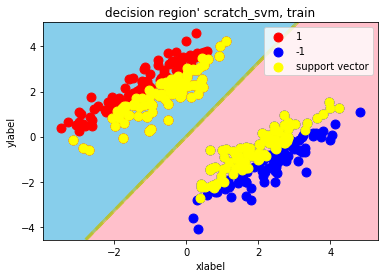

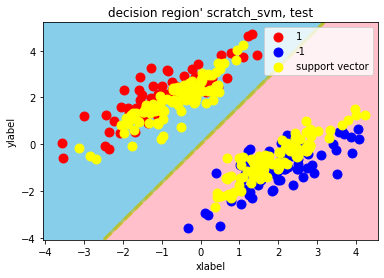

In [40]:
model = scratch_svm
model_name = "scratch_svm"
decision_region(X_train_transformed, y_train, model, title="decision region' {}, {}".format(model_name, "train"))
decision_region(X_test_transformed, y_test, model, title="decision region' {}, {}".format(model_name, "test"))

サポートベクター